In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fromscratch
pretrained
fromscratch_||
pretrained_||


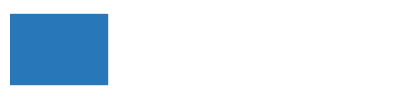

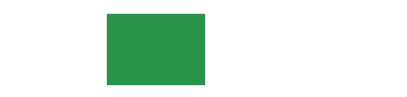

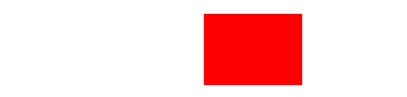

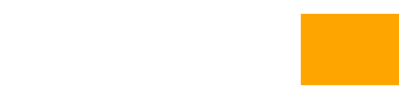

In [2]:
N_Ensemble = 10  #Currently placeholdef for FULL PASSES (5 ensembles each)
par_dir = "/global/cfs/cdirs/m3246/twamorka/H1Unfold_Vinny/H1Unfold/plots/" #dir for Tanvi's parallel ensembles
#main_dir = "H1_Feb_Seed1234_emaGetSetWeighs_archL61_closure_ITER4/"
run = 'H1_Feb_Seed1234_emaGetSetWeighs_archL61'
run += '_closure'
#labels = {'fromscratch':'Baseline', 'pretrained':'PreTrained','finetuned':'Finetuned',}
labels = {'fromscratch':'Step Baseline', 'pretrained':'Step Pre-trained'}
labels['fromscratch_||'] = 'Parallel Baseline'
labels['pretrained_||'] = 'Parallel Pre-trained'

color_maps = ["Blues","Reds","Greens"]
color_maps = ["Reds", "Greens", "Blues"]
color_maps = ['Blues', 'Greens', "Red", ]
marker_list= ['d','P','o', '>']
color_list = ['#2878B9', '#2a924a', 'Red', 'Orange']

markers = {}
for i,key in enumerate(labels.values()):
    markers[key] = marker_list[i]


colors = {}
for i,key in enumerate(labels.keys()):
    print(key)
    colors[key] = color_list[i]

for i, key in enumerate(colors.keys()):
    plt.figure(figsize=(5, 1))
    plt.fill_between([i, i+1], 0, 1, color=colors[key])
    plt.xlim(0, 4)
    plt.axis('off')

#colors = {}
#for key, c in zip(labels.keys(), color_maps):
#    colors[key] = plt.get_cmap(c)(np.linspace(0.5, 0.9, N_Ensemble))

#for key in colors:
#    plt.figure(figsize=(5, 1))
#    [plt.fill_between([i, i+1], 0, 1, color=c) for i, c in enumerate(colors[key])]
#    plt.xlim(0, N_Ensemble)
#    plt.axis('off')

In [3]:
#colors['pretrained'][N_Ensemble//2]

# Plot Code

In [4]:
def get_stdv_from_files(files, truth=None):

    data = [np.load(file) for file in files]
    
    # Initialize a dictionary to hold lists of y-values for each x-value index
    y_values_per_x_index = {}
    ratio_values_per_x_index = {}
    x_values = np.load(files[0])[0]  # Load the x-values from the first file


    for single_file_data in data:
        for i, y in enumerate(single_file_data[1]):  # single_file_data[1] are the y-values
            if i not in y_values_per_x_index:
                y_values_per_x_index[i] = []
            y_values_per_x_index[i].append(y)        
    
        for i, r in enumerate(single_file_data[2]):  # single_file_data[1] are the y-values
            if i not in ratio_values_per_x_index:
                ratio_values_per_x_index[i] = []
            ratio_values_per_x_index[i].append(r)
            
    if truth is None: #Standard Deviation, using Means
        std_devs = [np.std(y_values)/np.mean(y_values) for y_values in y_values_per_x_index.values()]
        ratio_std_devs = [np.std(y_values) for y_values in ratio_values_per_x_index.values()]

    else: #MSE, from truth. Usually Djanhog in the closure studies
        std_devs = [np.mean([(y - truth[1][i]) ** 2 for y in y_values])/np.mean(truth[1][i]) for i, y_values in y_values_per_x_index.items()]
        ratio_std_devs = [np.mean([(y - truth[2][i]) ** 2 for y in y_values]) for i, y_values in ratio_values_per_x_index.items()]
        
        #ratio_std_devs = [np.mean([(y - truth[2][i]) ** 2 for y in y_values]) for i, y_values in ratio_values_per_x_index.items()]

    return x_values, std_devs, ratio_std_devs

In [5]:
def plot_feature(dic, run, feature, feature_label, unit='', avg_Npts=0):
    
    # Create the overall figure and outer grid
    fig = plt.figure(figsize=(20, 5))
    outer_gs = gridspec.GridSpec(1, 3, figure=fig, hspace=0.3, wspace=0.2) #1 row, 3 cols, with padding
    
    alpha = 0.8
    label_size = 16
    E_Max = 5

    # Load baseline data using the first version key
    version = list(dic.keys())[0]
    #rapgap = np.load(f'Rapgap_{run}_{version}_{feature}_ens0_plot_vals.npy')
    rapgap = np.load(f'Rapgap_{run}_job1_{version}_{feature}_ensAvg_plot_vals.npy')
    djangoh = np.load(f'Djangoh_{run}_{version}_{feature}_ens0_plot_vals.npy')
    len_rapgap = len(rapgap[0])
    
    if avg_Npts:
        plot_rapgap = np.mean(rapgap[:, :rapgap.shape[1] // avg_Npts * avg_Npts].reshape(rapgap.shape[0], -1, avg_Npts), axis=2)
        plot_djangoh = np.mean(djangoh[:, :djangoh.shape[1] // avg_Npts * avg_Npts].reshape(djangoh.shape[0], -1, avg_Npts), axis=2)
    else:
        plot_rapgap = rapgap
        plot_djangoh = djangoh
    var_sup_str = r'$\sigma = \langle(\mathrm{value} - \mu^\mathrm{ensembles})^2\rangle$'
    var_metric = r'$\sigma_\mathrm{rel.}$'
    mse_sup_str = r'MSE = $\langle(\mathrm{value} - \mathrm{truth})^2\rangle$'
    mse_metric = '$\mathrm{MSE}_\mathrm{rel.}$'

    # -------------------------------
    # FIRST PANEL: Split into two subplots
    # -------------------------------
    # Create an inner grid for the first panel (top: main plot, bottom: ratio)
    inner_gs = gridspec.GridSpecFromSubplotSpec(
        2, 1, subplot_spec=outer_gs[0], height_ratios=[3, 1], hspace=0.05
    )
    ax1_top = fig.add_subplot(inner_gs[0])
    ax1_bottom = fig.add_subplot(inner_gs[1], sharex=ax1_top)

    # --- Top Subplot: Main Plot ---
    r_scatter = ax1_top.scatter(
        plot_rapgap[0], plot_rapgap[1],
        marker='_', label='Rapgap',
        alpha=alpha, s=100, color='k'
    )
    d_scatter = ax1_top.fill_between(
        plot_djangoh[0], plot_djangoh[1],
        step='mid', color='gray',
        alpha=0.3, label='Djangoh'
    )
    first_legend = ax1_top.legend(
        handles=[r_scatter, d_scatter],
        loc='lower left', fontsize=7
    )
    #ax1_top.add_artist(first_legend)

    ax1_top.set_ylabel(f'{feature_label}', fontsize=18)
    #ax1_top.set_ylabel('Normalized Counts', fontsize=label_size)
    ax1_top.tick_params(axis='both', which='major', labelsize=12)
    # Remove x-axis tick marks and labels on the top subplot
    ax1_top.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    #ax1_top.grid(True)

    # --- Bottom Subplot: Ratio Plot ---
    ax1_bottom.set_ylabel(r'Ratio', fontsize=label_size)
    ax1_bottom.set_xlabel(f'{feature_label} {unit}', fontsize=label_size)
    ax1_bottom.set_ylim(0.5, 1.5)
    ax1_bottom.tick_params(axis='both', which='major', labelsize=12)
    ax1_bottom.grid(True)
    ax1_bottom.scatter(plot_rapgap[0], plot_rapgap[1]/plot_djangoh[1], s=100, alpha=alpha, marker='_',color='k')

    # -------------------------------
    # Panels 2 and 3 remain unchanged
    # -------------------------------
    ax2 = fig.add_subplot(outer_gs[1])
    ax3 = fig.add_subplot(outer_gs[2])
    handles = []
    handles.append(r_scatter)
    handles.append(d_scatter)

    for version, label in dic.items():
        #raw_filename = 'Rapgap_unfoldedAvg_H1_March_ModelLists_5lrscale_patience10_parallel_closure_job5_pretrained_particle2_ensAvg_plot_vals.npy'
        #pt_par_file = 'Rapgap_unfoldedAvg_H1_March_ModelLists_5lrscale_patience10_parallel_closure_job5_pretrained_particle2_ensAvg_plot_vals.npy
        dir = './'
        temp = version
        if '||' in version:
            version = version[:-3]
            run = 'H1_March_ModelLists_5lrscale_patience10_parallel_closure'
            dir = './parallel_files/'
            #continue

        #First Panel: Plot overlay of observable for each ensembleA
        files = glob.glob(f'{dir}Rapgap_unfoldedAvg_{run}_job[0-{N_Ensemble-1}]_{version}_{feature}_ensAvg_plot_vals.npy')[:N_Ensemble]
        files.append(glob.glob(f'{dir}Rapgap_unfoldedAvg_{run}_job[1][0-9]_{version}_{feature}_ensAvg_plot_vals.npy'))
        files = files[:N_Ensemble]

        version = temp

                    

        running_avg = np.zeros(len_rapgap)
        ratio_avg = np.zeros(len_rapgap)
        plot_all_ensembles = False
        for n, file in enumerate(files):
            step_data = np.load(file)
            running_avg += step_data[1]
            ratio_avg += step_data[2]
            step_shift = max(step_data[0]) / len(step_data[0]) / 10 / (n + 1)
            
            if plot_all_ensembles:
                handles.append(ax1_top.scatter(
                    step_data[0] - step_shift, step_data[1],
                    marker=markers[version], color=colors[version][n],
                    alpha=alpha - 0.1, label=f'{label} {n}'
                ))
                ax1_bottom.scatter(
                    step_data[0] - step_shift, step_data[2],
                    marker=markers[version], color=colors[version][n],
                    alpha=alpha, label=f'{label} Ens. {n}'
                )
                
        running_avg = running_avg / len(files)
        ratio_avg = ratio_avg / len(files)

        ax1_top.set_ylim(0, 1.6*np.max(running_avg))
        
        if avg_Npts:
            running_avg = np.mean(np.array(running_avg[:len(running_avg) // avg_Npts * avg_Npts]).reshape(-1, avg_Npts), axis=1)
            ratio_avg = np.mean(np.array(ratio_avg[:len(ratio_avg) // avg_Npts * avg_Npts]).reshape(-1, avg_Npts), axis=1)
            avg_x = step_data[0][:len(running_avg) * avg_Npts:avg_Npts]
            avg_x = plot_rapgap[0]
            handles.append(ax1_top.scatter(avg_x, running_avg, label=f"{label}", color=colors[version]))
            ax1_bottom.scatter(avg_x, ratio_avg, label=f"{label}", color=colors[version],marker=markers[label])
            
        else:
            handles.append(ax1_top.scatter(step_data[0], running_avg, label=f"{label}", color=colors[version],marker=markers[label]))
            ax1_bottom.scatter(step_data[0], ratio_avg, label=f"{label}", color=colors[version],marker=markers[label])
        
        first_legend = ax1_top.legend(handles=handles, fontsize=12, ncol=2, columnspacing=0.2)
        ax1_top.grid(True)

        #ax1_top.legend(handles=handles, ncol=2, fontsize=9)

        x_values, std_devs, ratio_std_devs = get_stdv_from_files(files, None)  # standard deviation
        x_values, MSEs, ratio_MSEs = get_stdv_from_files(files, djangoh)         # MSE

        # Second Panel: Standard Deviation ensembles for different run types (Baseline, Pre-Trained, etc...)
        if avg_Npts:
            std_devs = np.mean(np.array(std_devs[:len(std_devs) // avg_Npts * avg_Npts]).reshape(-1, avg_Npts), axis=1)
            MSEs = np.mean(np.array(MSEs[:len(MSEs) // avg_Npts * avg_Npts]).reshape(-1, avg_Npts), axis=1)
            x_values = x_values[:len(std_devs) * avg_Npts:avg_Npts]

        ax2.plot(x_values, std_devs, marker=markers[label], linestyle='-',
            label=label, color=colors[version])

        
        ax2.set_ylabel(f'{var_metric}', fontsize=18)
        #ax2.set_ylabel(var_metric, fontsize=label_size)#
        ax2.set_xlabel(f'{feature_label} {unit}', fontsize=label_size)
        ax2.tick_params(axis='both', which='major', labelsize=12)
        ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        ax2.grid(True)

        # Third Panel: MSE of ensembles, where Django=Truth
        ax3.plot(
            x_values, MSEs, marker=markers[label], linestyle='-',
            label=label, color=colors[version]
        )
        ax3.set_ylabel(f'{mse_metric}', fontsize=18)
        ax3.set_ylabel(mse_metric, fontsize=label_size)
        ax3.set_xlabel(f'{feature_label} {unit}', fontsize=label_size)
        ax3.tick_params(axis='both', which='major', labelsize=12)
        ax3.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        ax3.grid(True)

    ax1_top.add_artist(first_legend)
    ax2.legend(fontsize=12)
    ax3.legend(fontsize=12)
    #plt.tight_layout()
    plt.savefig(f'{feature}_BaseLineVsPretrain.pdf')
    plt.show()


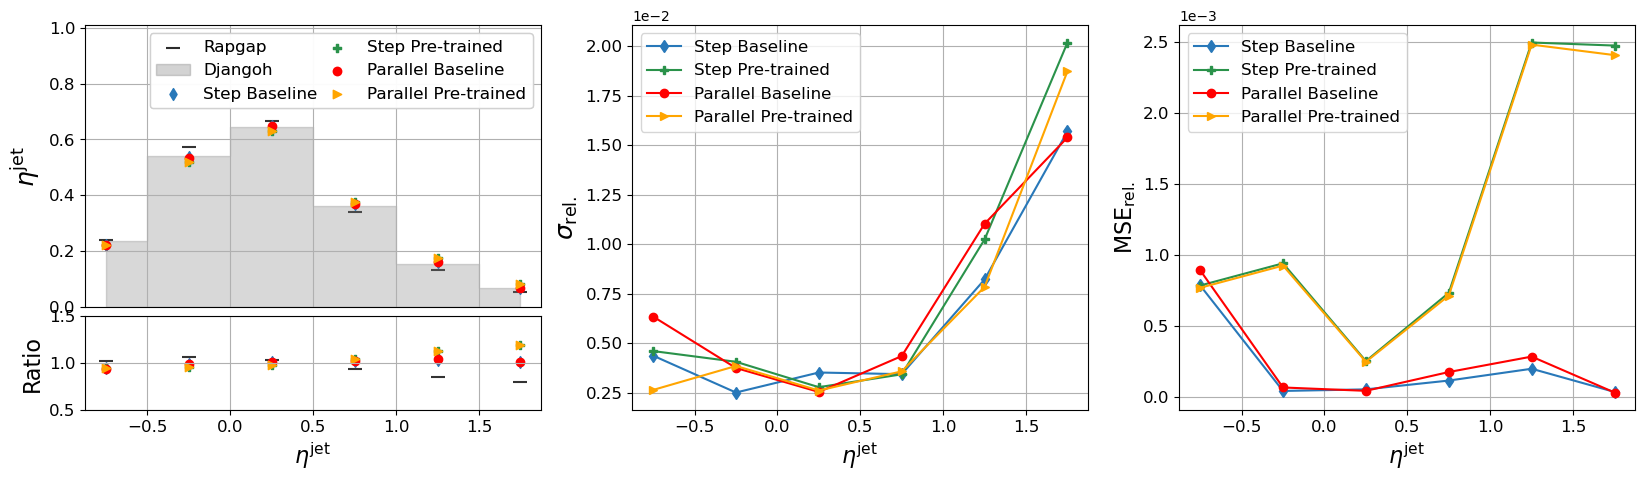

In [6]:
plot_feature(labels, run, 'jet_eta', r'$\eta^\mathrm{jet}$')

# Jets

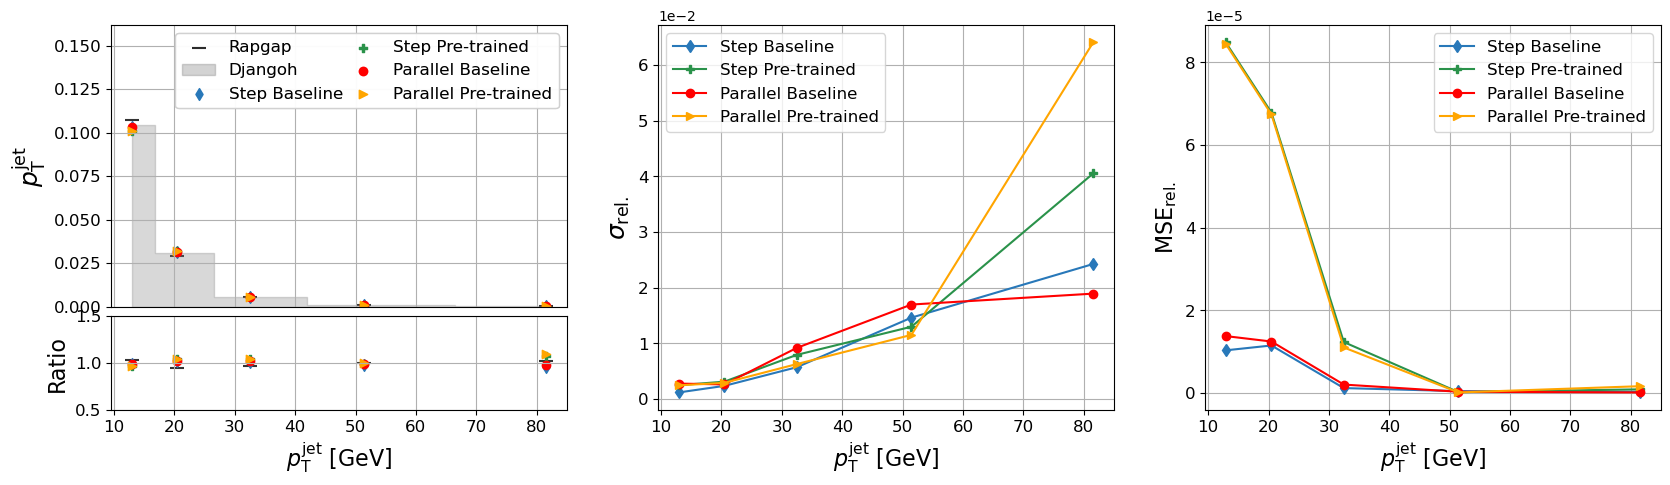

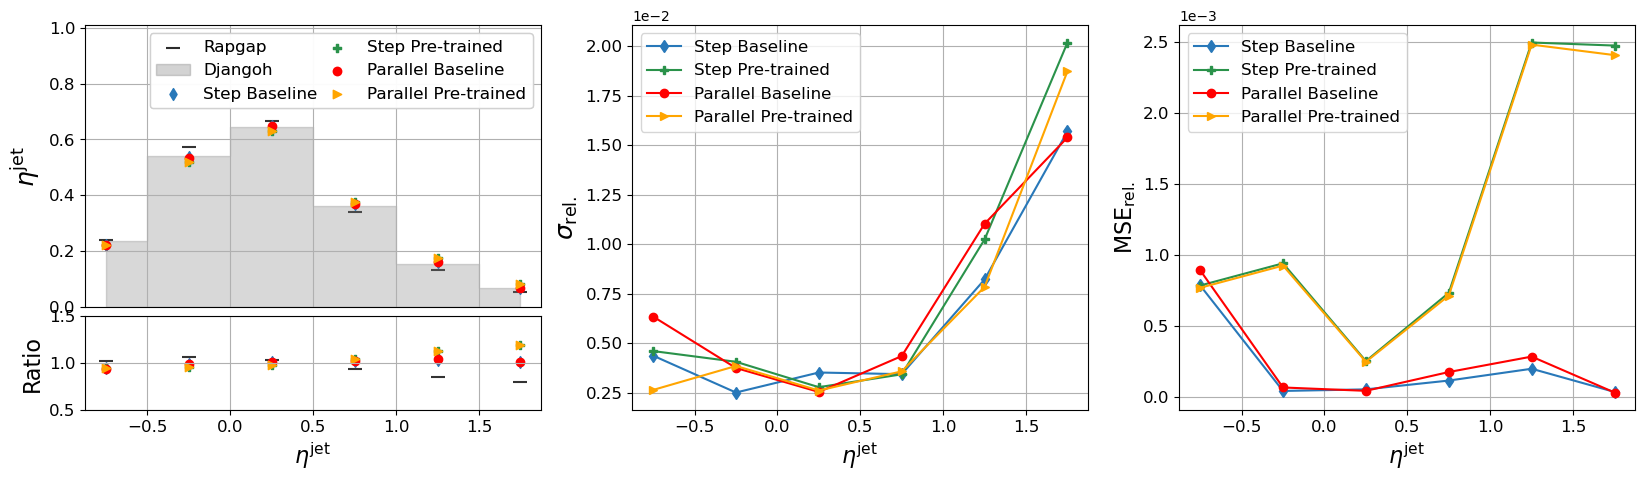

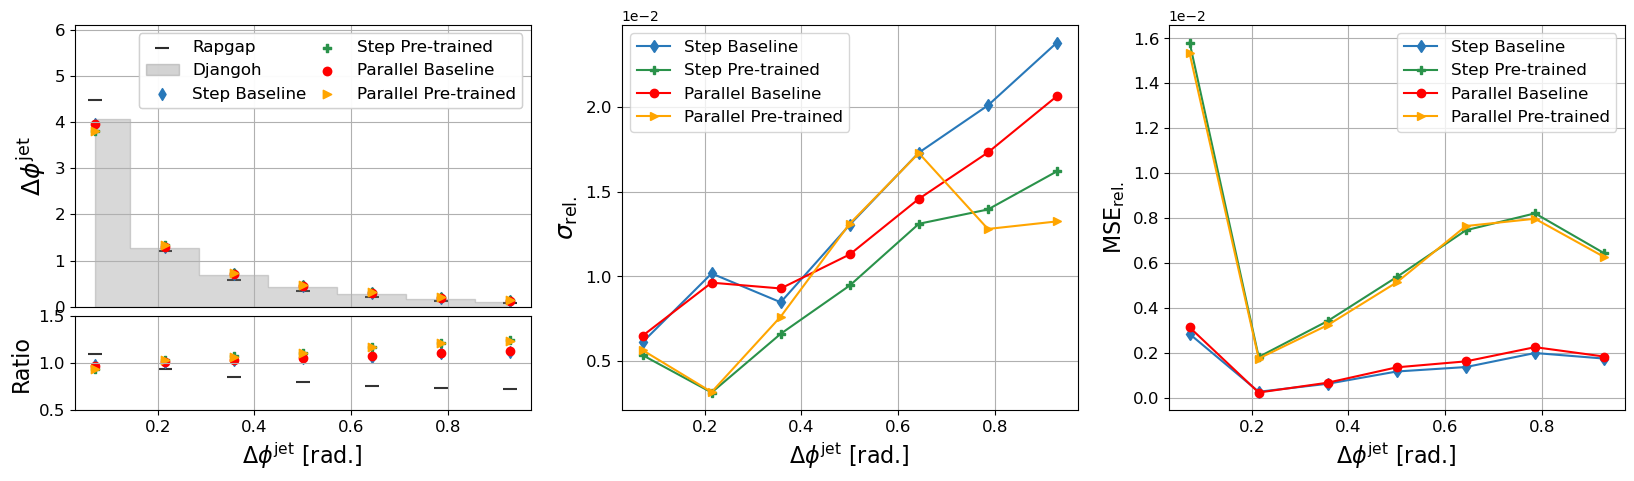

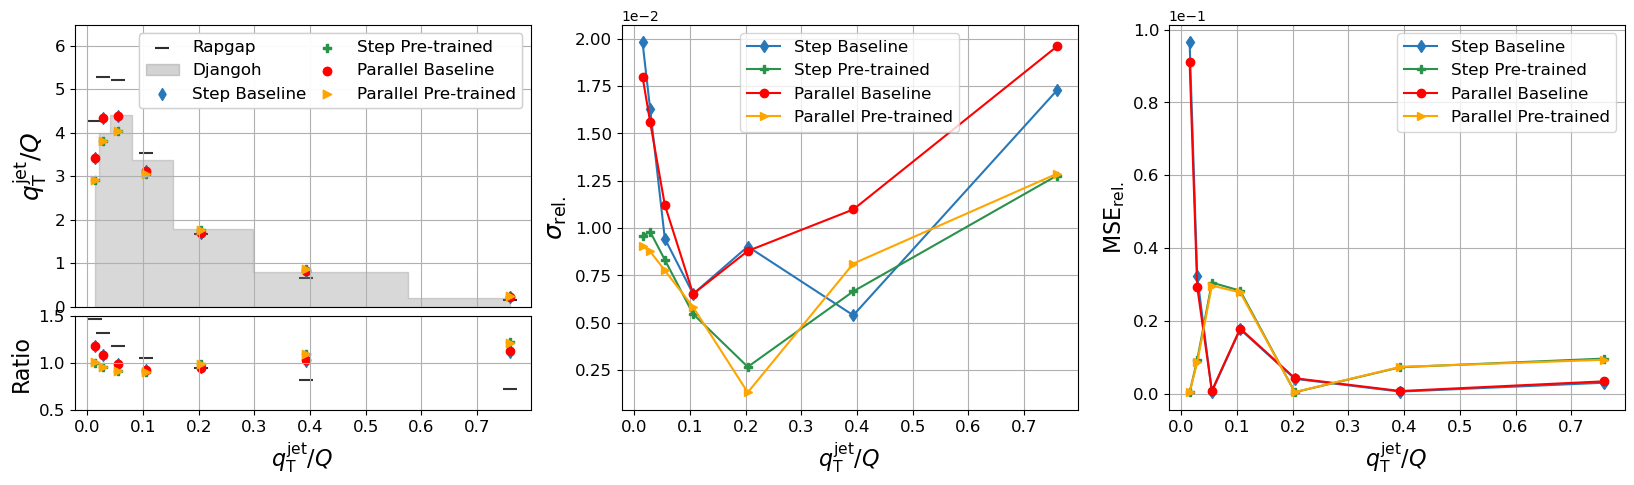

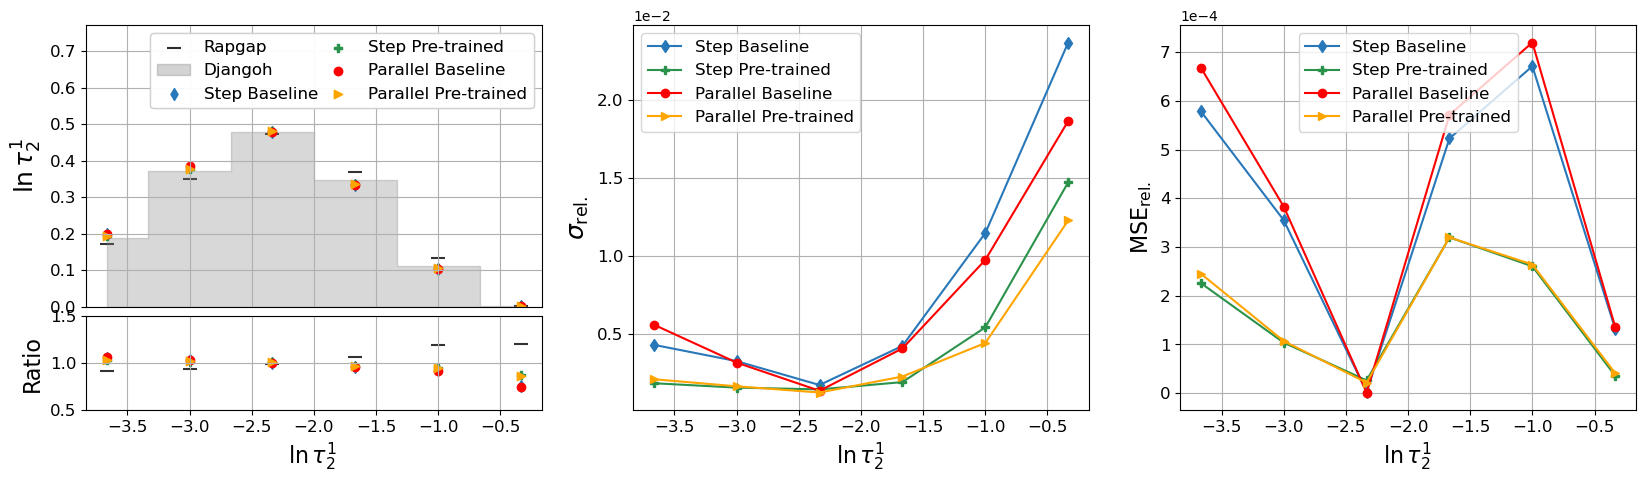

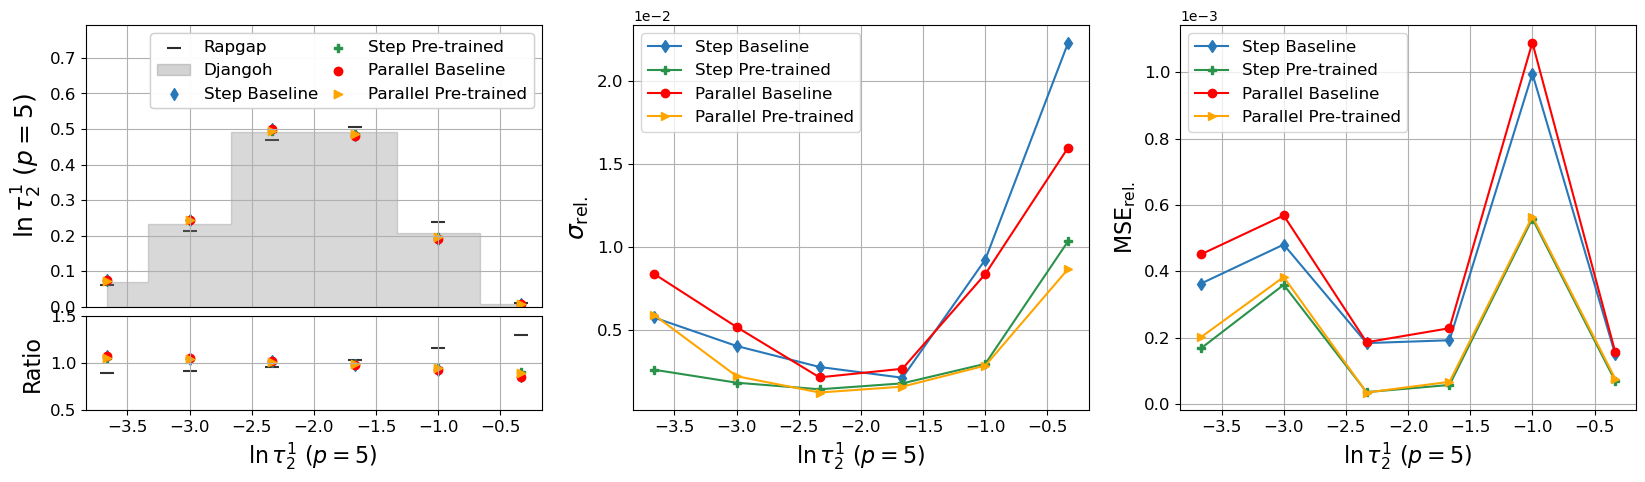

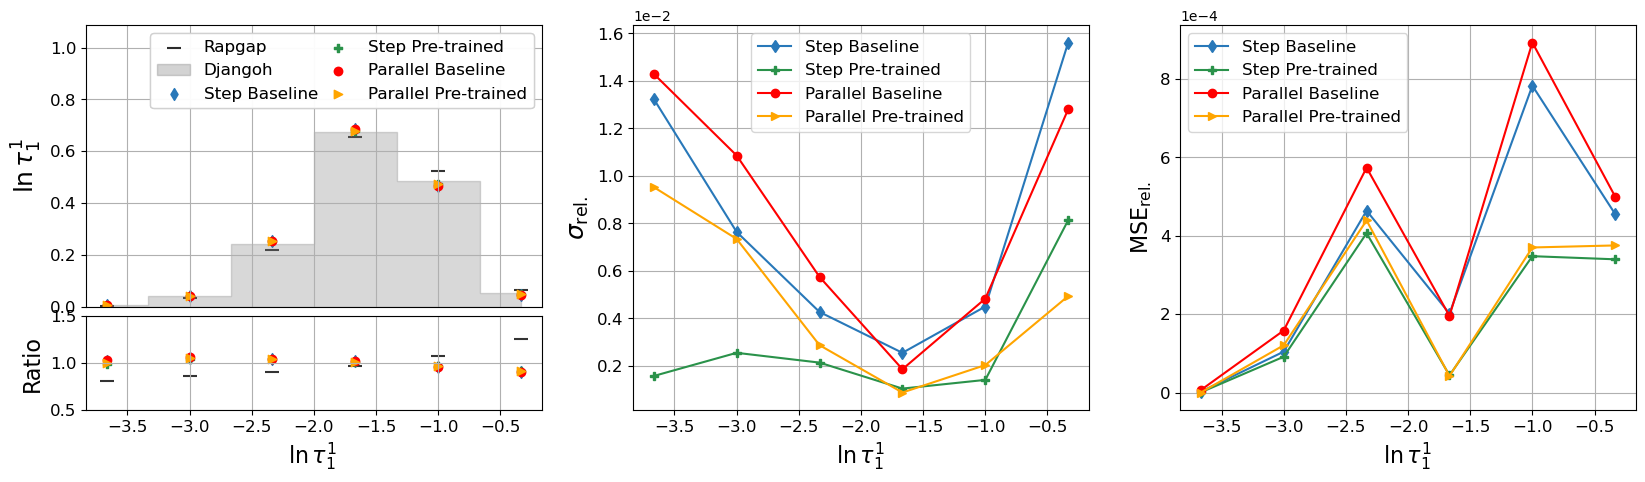

/tmp/ipykernel_2220076/697527909.py:23: RuntimeWarning: invalid value encountered in scalar divide
  std_devs = [np.std(y_values)/np.mean(y_values) for y_values in y_values_per_x_index.values()]


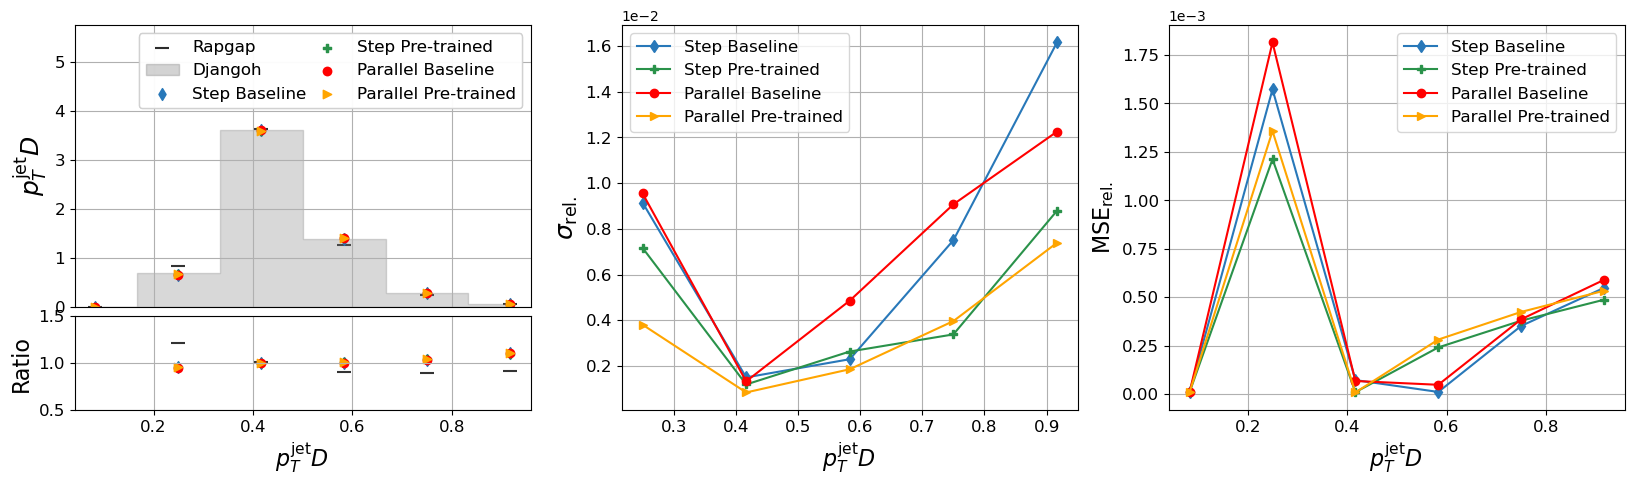

In [7]:
jet_features = ['jet_pT', 'jet_eta', 'jet_phi', 'jet_qT', 'jet_tau12', 'jet_tau11p5', 'jet_tau11', 'jet_ptD']
jet_labels = [r'$p_\mathrm{T}^\mathrm{jet}$',r'$\eta^\mathrm{jet}$',
              r'$\Delta\phi^\mathrm{jet}$',r'$q_\mathrm{T}^\mathrm{jet}/Q$', 
              r'$\ln\tau^1_2$', r'$\ln\tau^1_2\ (p=5)$', r'$\ln\tau^1_1$', '$p^\mathrm{jet}_{T}D$']
units = ['[GeV]','','[rad.]','','','','','']

for jet_feature, jet_label, unit in zip(jet_features, jet_labels, units):
    plot_feature(labels, run, jet_feature, jet_label, unit)
    print()

# Events

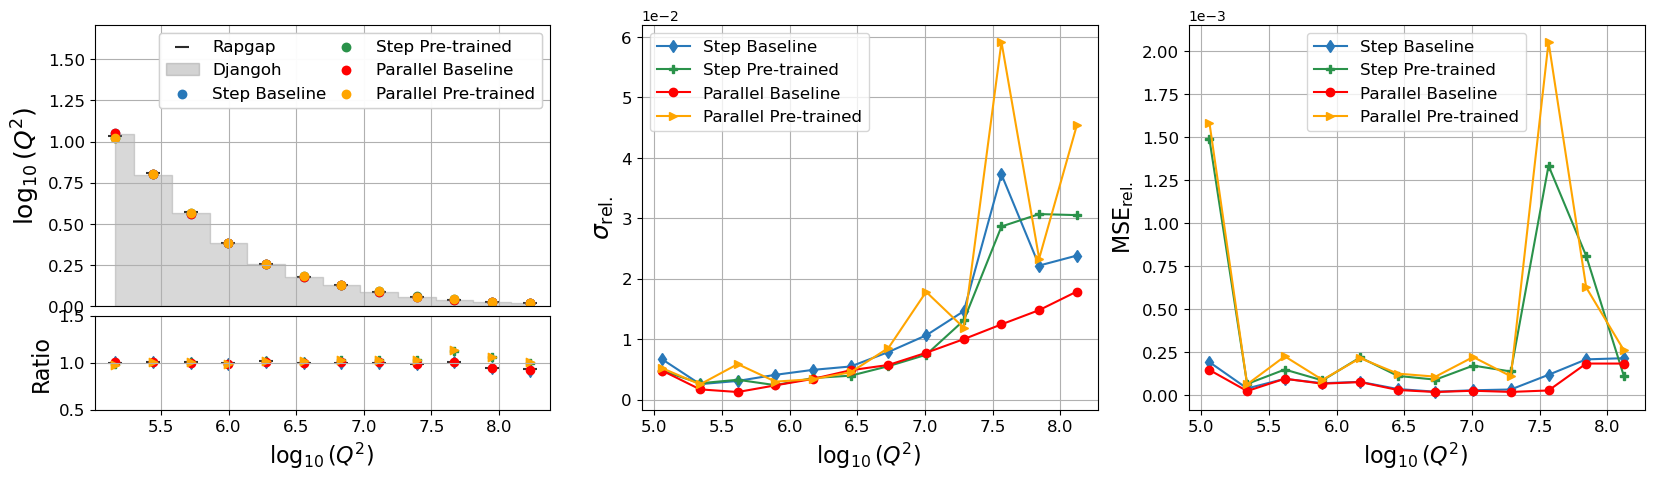

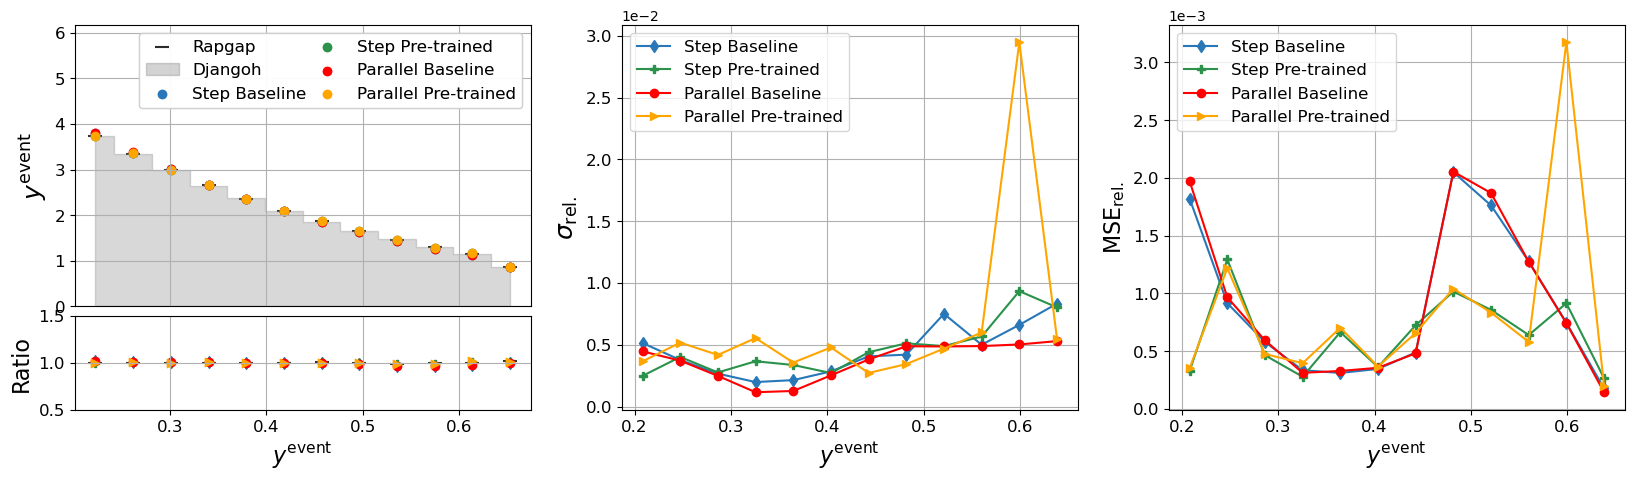

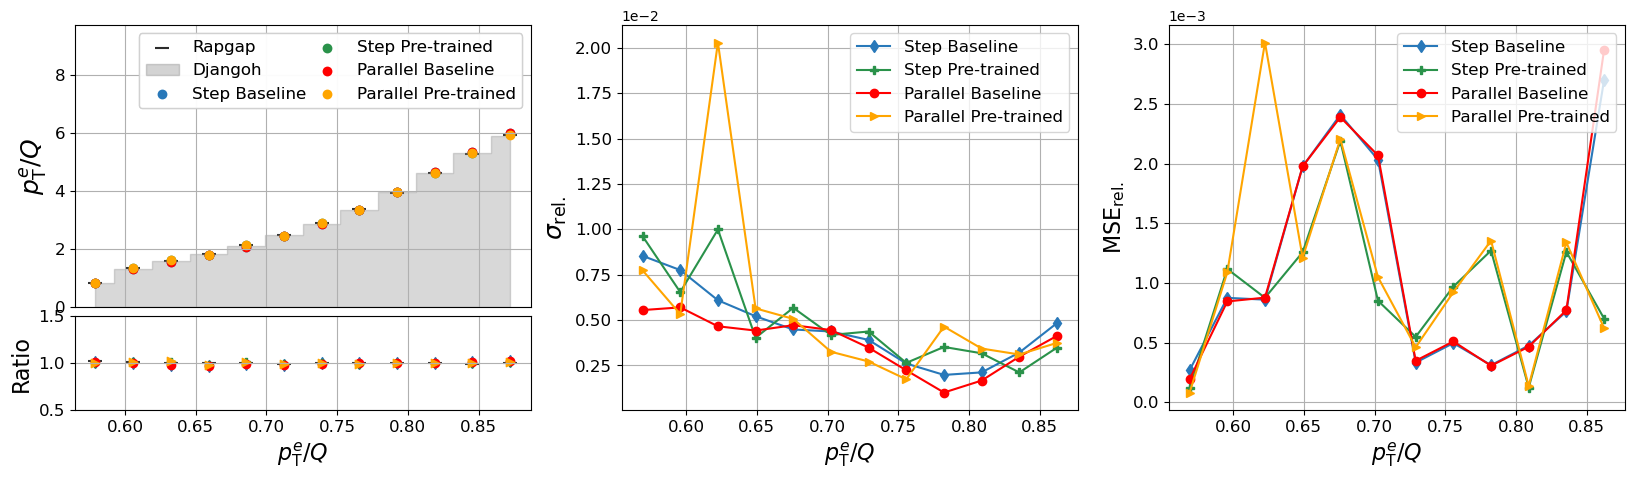

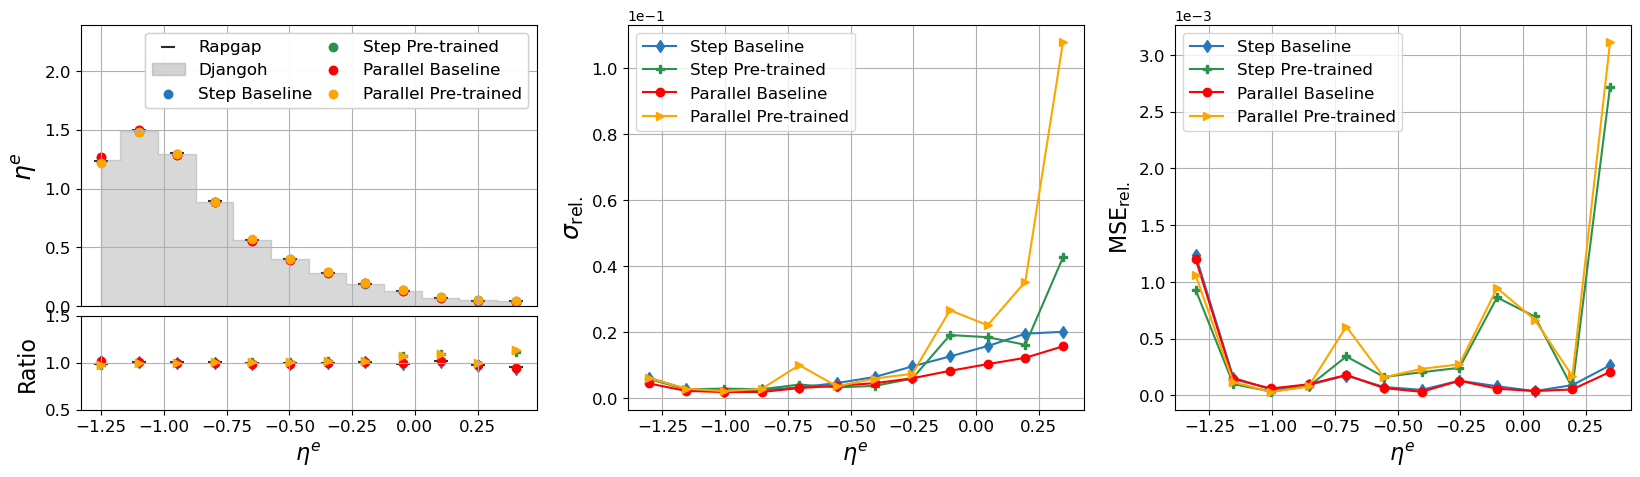

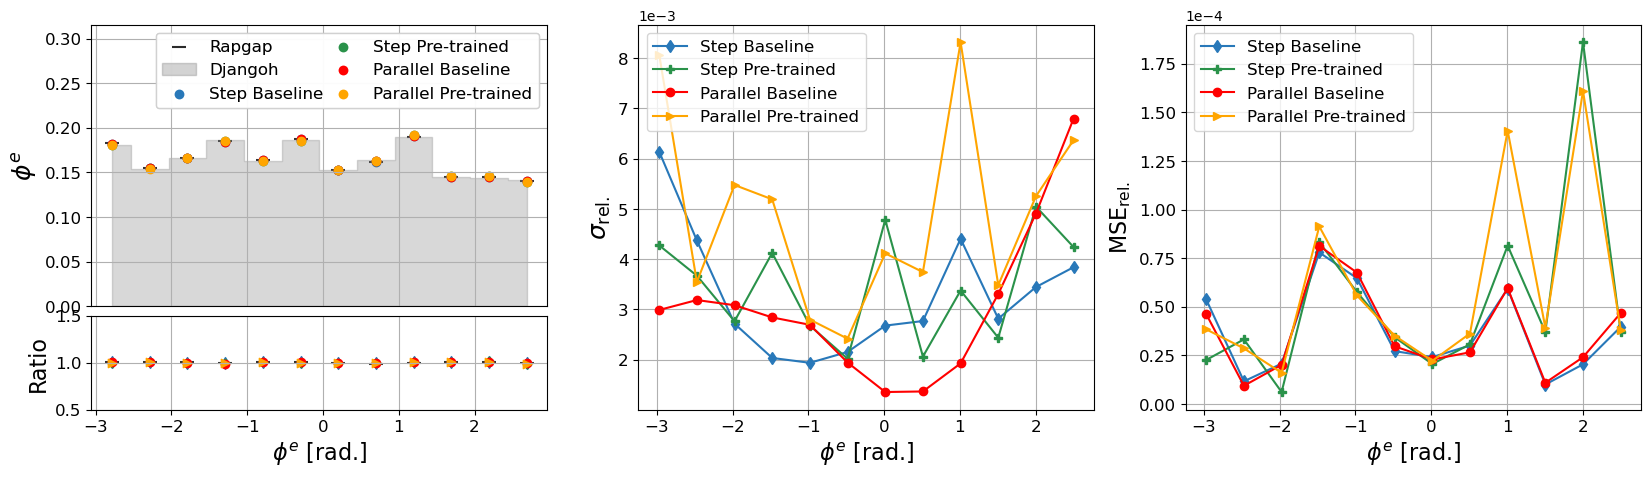

In [8]:
event_labels = [r'$\log_{10}(Q^2)$',r'$y^\mathrm{event}$',r'$p_\mathrm{T}^e/Q$',r'$\eta^e$',r'$\phi^e$']
event_features = [f"event{e}" for e in range(len(event_labels))]
units = ["", "", "", "", "[rad.]"]
avg_Npts = 4

for event_feature, event_label, unit in zip(event_features, event_labels, units):
    plot_feature(labels, run, event_feature, event_label, unit, avg_Npts)
    print()

#
# Particles
#

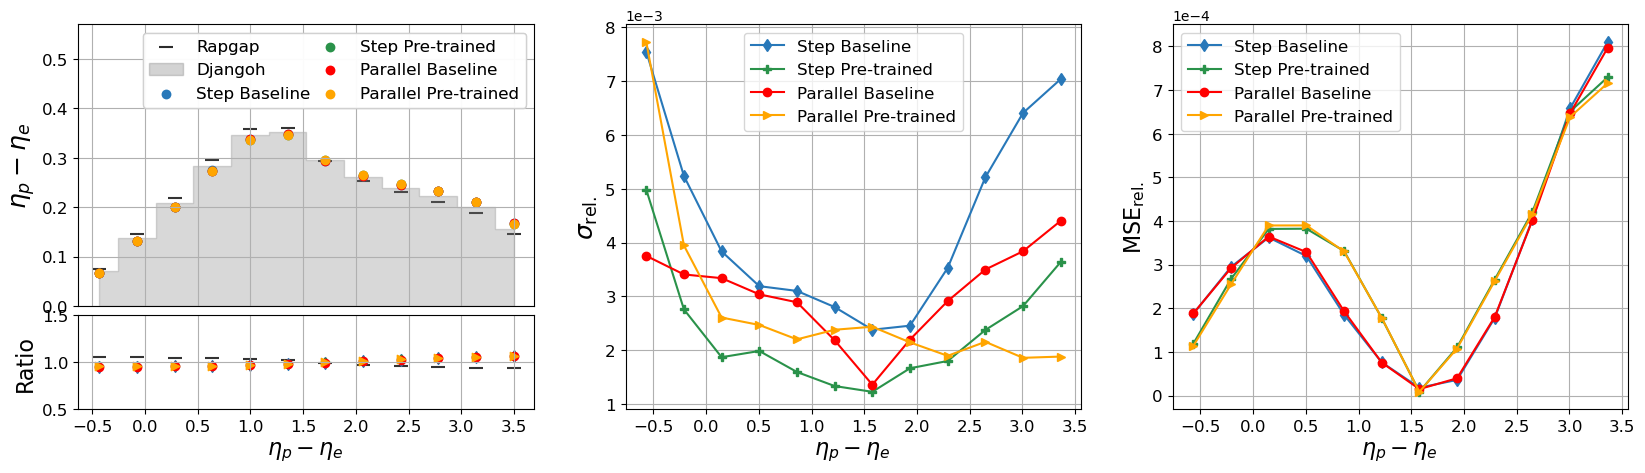

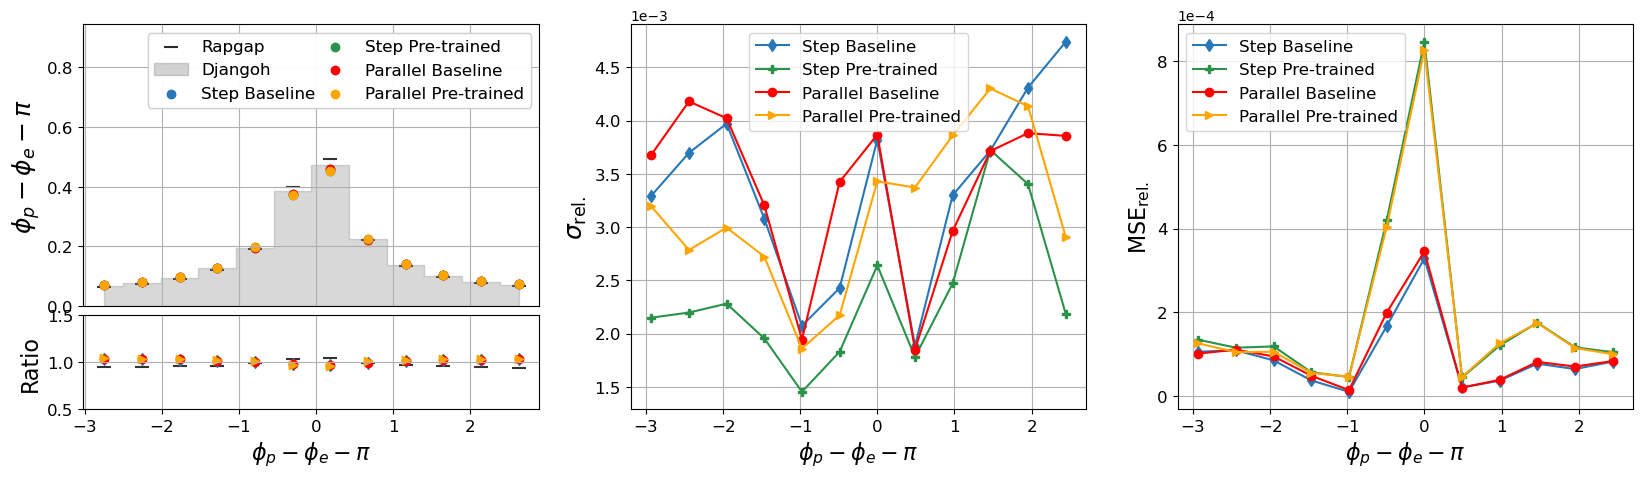

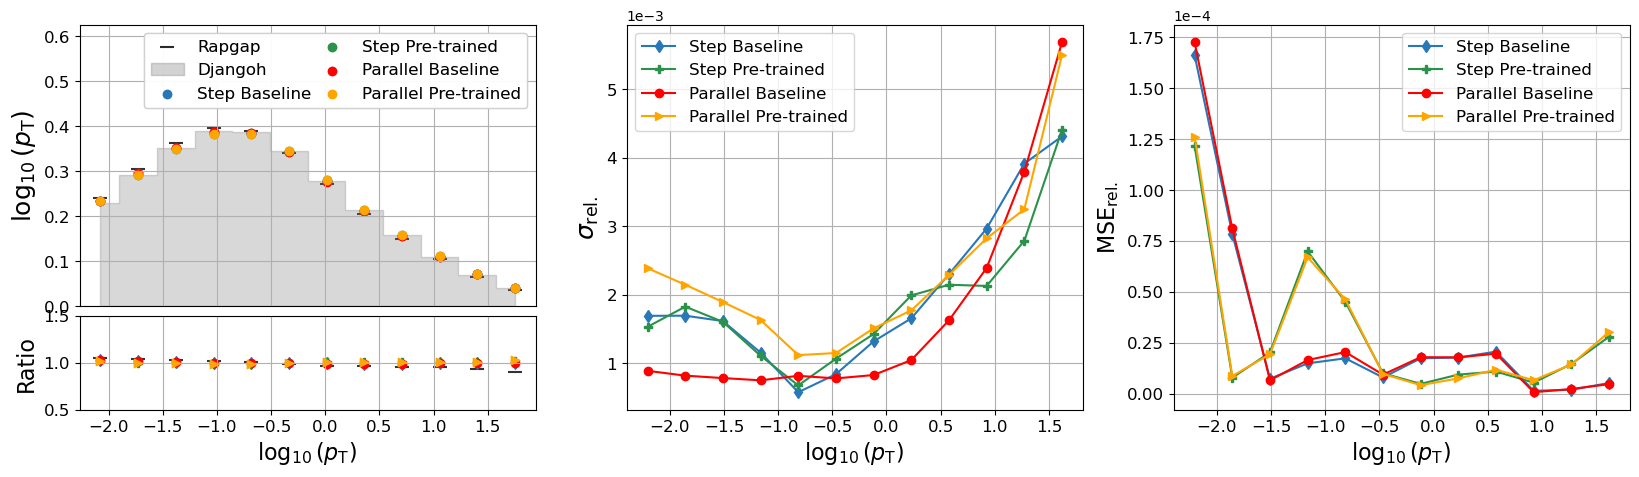

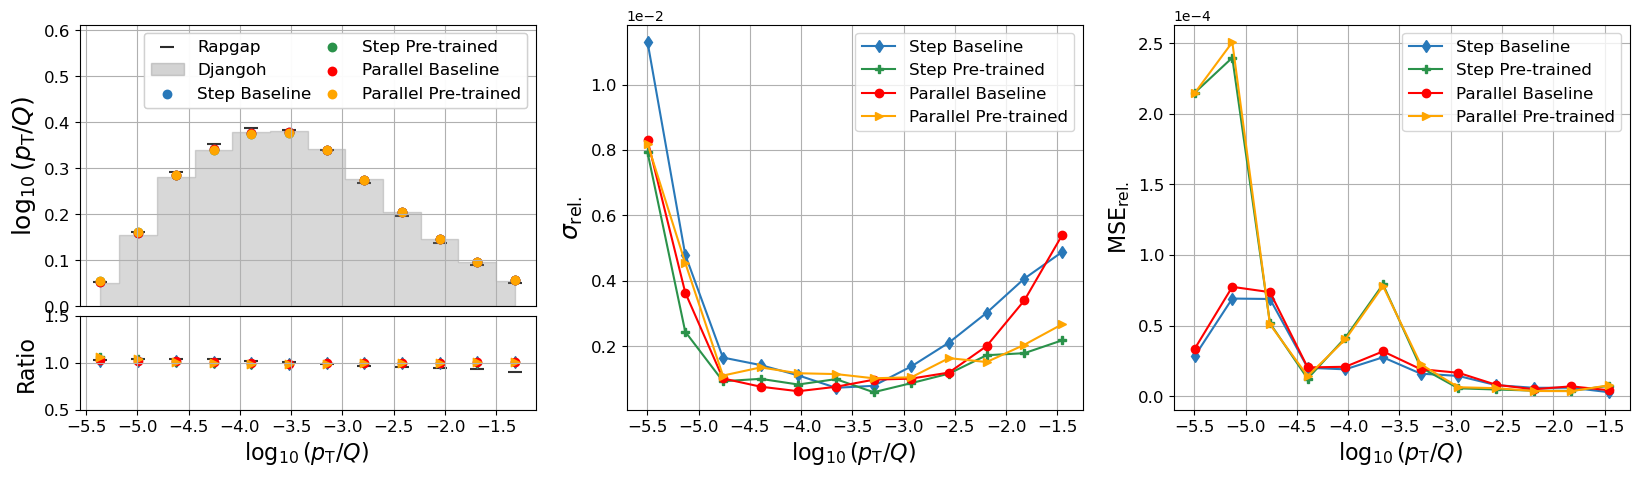

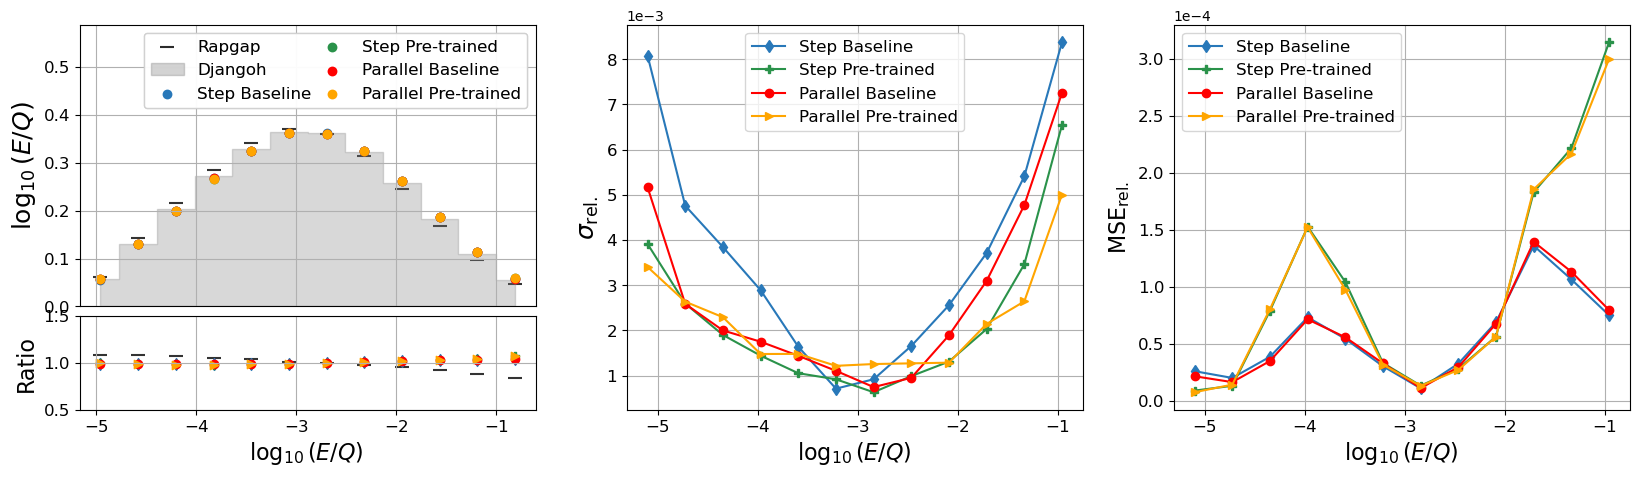

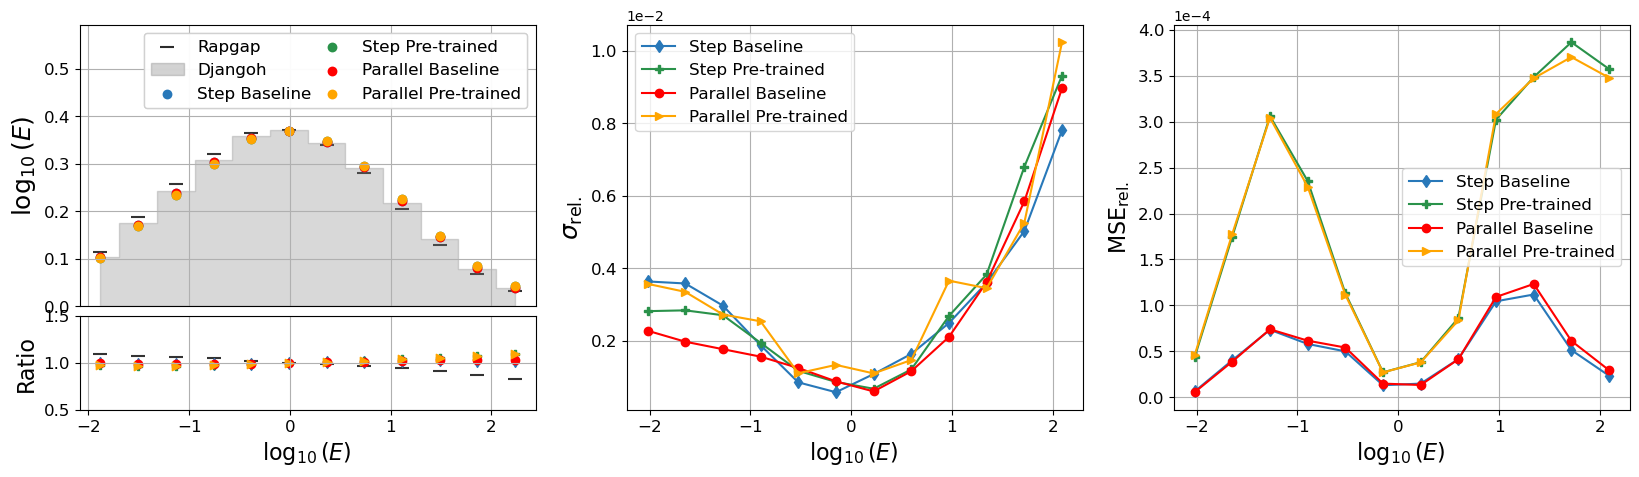

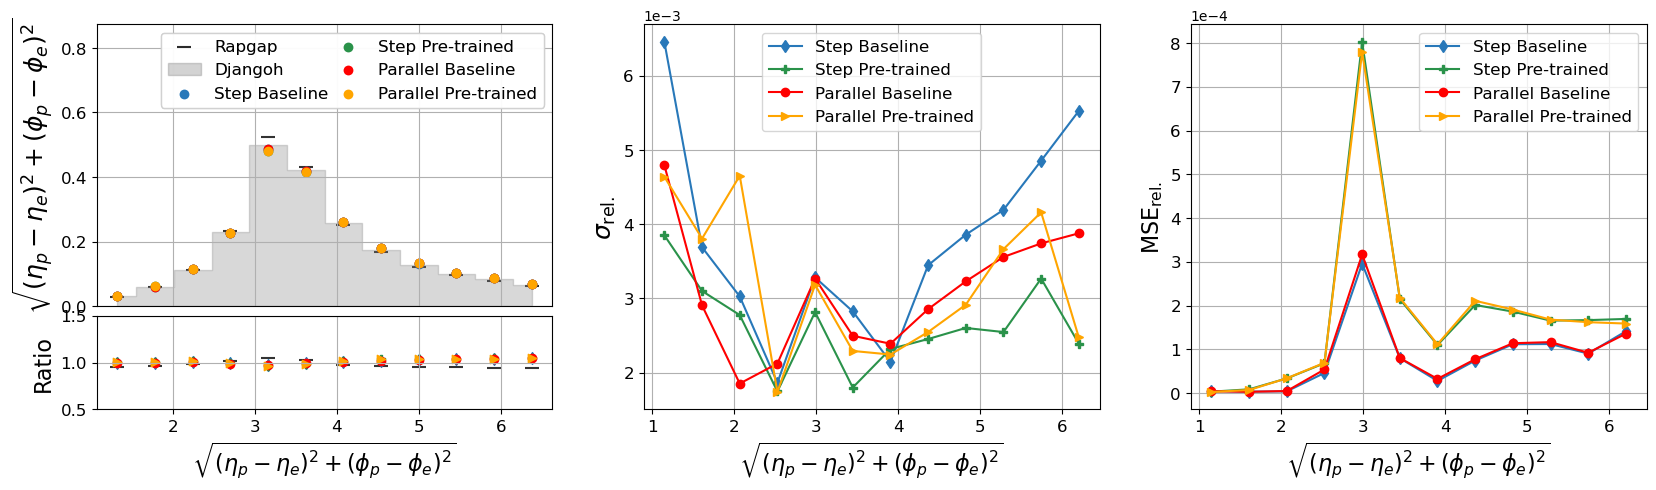

/tmp/ipykernel_2220076/18414187.py:69: RuntimeWarning: invalid value encountered in divide
  ax1_bottom.scatter(plot_rapgap[0], plot_rapgap[1]/plot_djangoh[1], s=100, alpha=alpha, marker='_',color='k')
/tmp/ipykernel_2220076/697527909.py:23: RuntimeWarning: invalid value encountered in scalar divide
  std_devs = [np.std(y_values)/np.mean(y_values) for y_values in y_values_per_x_index.values()]
/tmp/ipykernel_2220076/697527909.py:27: RuntimeWarning: invalid value encountered in scalar divide
  std_devs = [np.mean([(y - truth[1][i]) ** 2 for y in y_values])/np.mean(truth[1][i]) for i, y_values in y_values_per_x_index.items()]


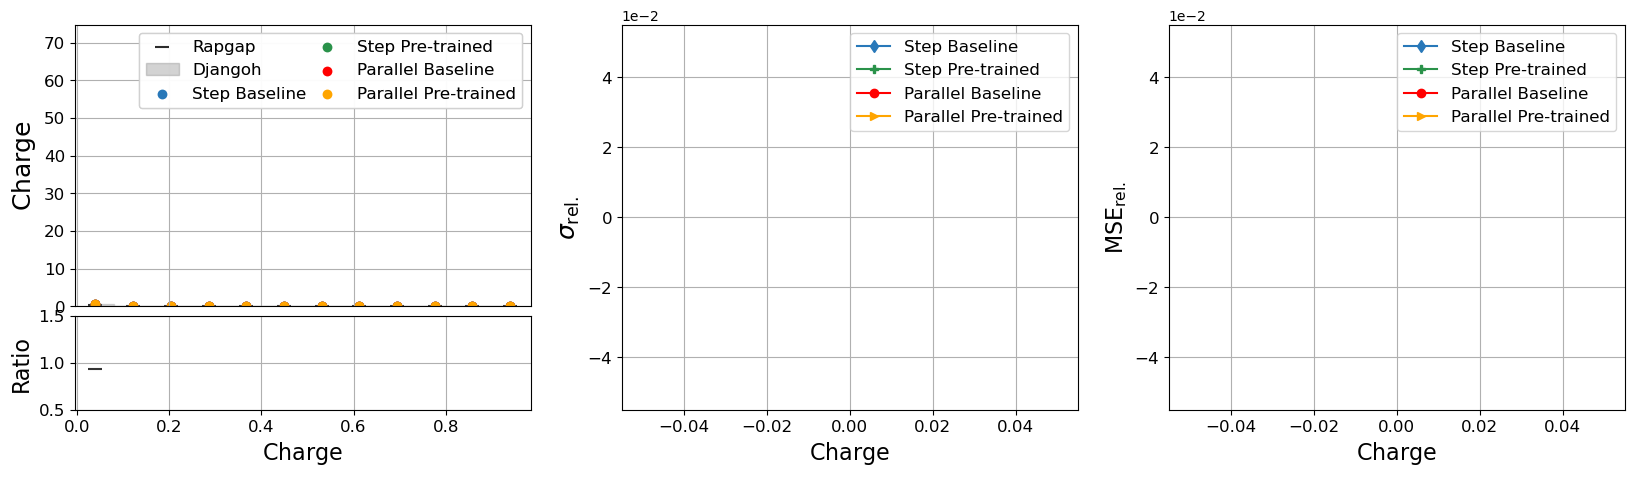

In [9]:
particle_labels = [
    '$\eta_p - \eta_e$',
    '$\phi_p-\phi_e-\pi$',
    '$\log_{10}(p_\mathrm{T})$',
    '$\log_{10}(p_\mathrm{T}/Q)$',
    '$\log_{10}(E/Q)$',
    '$\log_{10}(E)$',
    '$\sqrt{(\eta_p-\eta_e)^2+(\phi_p-\phi_e)^2}$',
    '$\mathrm{Charge}$']
particle_features = [f'particle{p}' for p in range(len(particle_labels))]
avg_Npts = 4

for particle_feature, particle_label in zip(particle_features, particle_labels):
    plot_feature(labels, run, particle_feature, particle_label, avg_Npts = avg_Npts)
    print()